## PHASE 1: DATA INGESTION & SPATIAL RECONSTRUCTION
To bridge the gap between our Python-based spatial analytics and a web-based React dashboard, we must prepare the final datasets. 

In Notebooks 1 and 2, we exported our spatial networks as CSV files. Here, we ingest those CSVs and reconstruct them back into active `GeoDataFrames`. 

**Critical Coordinate Reference System (CRS) Fix:** * Notebook 1 exported raw points in metric `EPSG:32737` (UTM Zone 37S). 
* Notebook 2 exported street routes downloaded from OSM in standard `EPSG:4326` (Lat/Long). 
Our ingestion engine correctly assigns the exact projection to each file to prevent geographical distortion.

In [15]:
# ==========================================
# NOTEBOOK 03: WEB DATA FORMATTING & METRICS
# ==========================================
import pandas as pd
import geopandas as gpd
from shapely import wkt
import os

# Define I/O directories using the absolute Windows path
input_dir = r"C:\Users\Administrator\Desktop\Nairobi_Transit_Optimizer\data\processed"
output_dir = r"C:\Users\Administrator\Desktop\Nairobi_Transit_Optimizer\data\processed\web_exports"
os.makedirs(output_dir, exist_ok=True)

print("Loading Transit Data from Notebook 1 & 2...")

# Helper function to load CSV with WKT geometry OR x/y coordinates safely
def load_spatial_csv(filepath):
    df = pd.read_csv(filepath)
    if 'geometry' in df.columns:
        df['geometry'] = df['geometry'].apply(wkt.loads)
        # NB2 exported routes as Lat/Long (EPSG:4326)
        return gpd.GeoDataFrame(df, geometry='geometry', crs="EPSG:4326")
    elif 'x' in df.columns and 'y' in df.columns:
        # NB1 exported points in UTM (EPSG:32737)
        return gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['x'], df['y']), crs="EPSG:32737")
    return df

# Ingest the datasets
gdf_destinations = load_spatial_csv(os.path.join(input_dir, "classified_destinations.csv"))
gdf_origins = load_spatial_csv(os.path.join(input_dir, "classified_origins.csv"))
gdf_rail = load_spatial_csv(os.path.join(input_dir, "nairobi_heavy_rail.csv"))
gdf_brt = load_spatial_csv(os.path.join(input_dir, "nairobi_brt_routes.csv"))
gdf_hubs = load_spatial_csv(os.path.join(input_dir, "nairobi_hubs.csv"))

print("[SUCCESS] All datasets loaded into GeoDataFrames.")

Loading Transit Data from Notebook 1 & 2...
[SUCCESS] All datasets loaded into GeoDataFrames.


## PHASE 2: FEASIBILITY & SPATIAL EQUITY MATHEMATICS
This section executes the mathematical proof of the "Spatial Mismatch." Instead of relying on arbitrary time-of-day metrics, we aggregate hard infrastructural data to quantify the commute penalty.

**Key Calculations:**
1. **Route Lengths:** We temporarily project the street routes into metric UTM to calculate the exact physical distance in kilometers, rather than degrees.
2. **The Spatial Equity Score (Commute Penalty):** We isolate Tier 1 (White-Collar) and Tier 3 (Blue-Collar) routes. By dividing the average Tier 3 route distance by the Tier 1 route distance, we calculate the commute penalty multiplier.
3. **Estimated Ridership:** We calculate the total population connected to each station, applying a realistic 15% transit adoption factor to estimate daily passenger volume.

In [16]:
print("Calculating Spatial Equity and Feasibility Metrics...")

# 1. Calculate Route Lengths (in kilometers)
# Temporarily project to UTM 37S (EPSG:32737) just for accurate metric length calculation
gdf_brt['route_distance_km'] = gdf_brt.to_crs("EPSG:32737").geometry.length / 1000
gdf_rail['track_length_km'] = gdf_rail.to_crs("EPSG:32737").geometry.length / 1000

# 2. Spatial Equity Score (The Commute Penalty)
tier_1_routes = gdf_brt[gdf_brt['tier'] == 'Tier_1_WhiteCollar']
tier_3_routes = gdf_brt[gdf_brt['tier'] == 'Tier_3_MiddleIncome']

avg_t1_dist = tier_1_routes['route_distance_km'].mean()
avg_t3_dist = tier_3_routes['route_distance_km'].mean()
commute_penalty_ratio = avg_t3_dist / avg_t1_dist if avg_t1_dist > 0 else 0

# 3. Population Connected (Assuming 15% adoption rate for BRT feeders)
ADOPTION_FACTOR = 0.15

# Grouping by the correct column 'target_hub' and aggregating 'population_weight'
hub_connectivity = gdf_brt.groupby('target_hub').agg(
    total_feeder_routes=('neighborhood', 'count'),
    total_population_served=('population_weight', 'sum'),
    avg_feeder_distance=('route_distance_km', 'mean')
).reset_index()

hub_connectivity['estimated_daily_ridership'] = hub_connectivity['total_population_served'] * ADOPTION_FACTOR

# 4. Compile the Executive Metrics
executive_metrics = pd.DataFrame([{
    'total_network_km': gdf_rail['track_length_km'].sum() + gdf_brt['route_distance_km'].sum(),
    'avg_tier1_commute_km': round(avg_t1_dist, 2),
    'avg_tier3_commute_km': round(avg_t3_dist, 2),
    'commute_penalty_multiplier': round(commute_penalty_ratio, 2),
    'total_daily_ridership_est': hub_connectivity['estimated_daily_ridership'].sum()
}])

print(f"[SUCCESS] Spatial Equity calculated. Tier 3 travels {commute_penalty_ratio:.2f}x further than Tier 1.")

Calculating Spatial Equity and Feasibility Metrics...
[SUCCESS] Spatial Equity calculated. Tier 3 travels 2.17x further than Tier 1.


## PHASE 3: WEB REPROJECTION, SANITY CHECK, & GEOJSON EXPORT
Modern web mapping engines like MapLibre GL JS operate on a strict, universal coordinate standard: **Web Mercator (`EPSG:4326`)**. 

Here, we reproject all points and lines to standard Lat/Long. Before we export, we run a final automated sanity check to ensure our map will not render in Antarctica and that our Executive Metrics are completely accurate. Once validated, the files are exported to the `web_exports` folder.

In [17]:
# 1. Reproject all spatial data to standard Latitude/Longitude (EPSG:4326)
gdf_dest_web = gdf_destinations.to_crs("EPSG:4326")
gdf_orig_web = gdf_origins.to_crs("EPSG:4326")
gdf_rail_web = gdf_rail.to_crs("EPSG:4326")
gdf_brt_web = gdf_brt.to_crs("EPSG:4326")
gdf_hubs_web = gdf_hubs.to_crs("EPSG:4326")

# 2. RUN SANITY CHECK
print("==================================================")
print(" FINAL DATA VERIFICATION & SANITY CHECK")
print("==================================================\n")

print("📊 1. METRICS CHECK (Looking for 2.17x Commute Penalty)")
display(executive_metrics)

print("\n🗺️ 2. SPATIAL GEOMETRY CHECK (Looking for EPSG:4326)")
geo_datasets = {
    "Heavy Rail Backbone": gdf_rail_web,
    "Feeder Routes (BRT)": gdf_brt_web,
    "Destinations (Hubs)": gdf_dest_web
}

for name, gdf in geo_datasets.items():
    print(f"\n[ {name} ]")
    print(f"  -> Features: {len(gdf)} | CRS: {gdf.crs}")
    print(f"  -> Valid Geometries: {gdf.geometry.notnull().sum() == len(gdf)}")

# 3. EXPORT TO WEB FOLDER
print("\n[EXPORTING TO DISK...]")
executive_metrics.to_csv(os.path.join(output_dir, "executive_metrics.csv"), index=False)
hub_connectivity.to_csv(os.path.join(output_dir, "hub_connectivity_stats.csv"), index=False)

gdf_dest_web.to_file(os.path.join(output_dir, "hubs_destinations.geojson"), driver="GeoJSON")
gdf_orig_web.to_file(os.path.join(output_dir, "residential_nodes.geojson"), driver="GeoJSON")
gdf_rail_web.to_file(os.path.join(output_dir, "heavy_rail_backbone.geojson"), driver="GeoJSON")
gdf_brt_web.to_file(os.path.join(output_dir, "feeder_routes.geojson"), driver="GeoJSON")
gdf_hubs_web.to_file(os.path.join(output_dir, "neighborhood_hubs.geojson"), driver="GeoJSON")

print(f"\n[COMPLETE] All web-ready files successfully exported to:")
print(f"  -> {output_dir}")
print("The data pipeline is fully closed.")

 FINAL DATA VERIFICATION & SANITY CHECK

📊 1. METRICS CHECK (Looking for 2.17x Commute Penalty)


,total_network_km,avg_tier1_commute_km,avg_tier3_commute_km,commute_penalty_multiplier,total_daily_ridership_est
0,433.15351,3.07,6.66,2.17,1.104990e+06



🗺️ 2. SPATIAL GEOMETRY CHECK (Looking for EPSG:4326)

[ Heavy Rail Backbone ]
  -> Features: 20 | CRS: EPSG:4326
  -> Valid Geometries: True

[ Feeder Routes (BRT) ]
  -> Features: 70 | CRS: EPSG:4326
  -> Valid Geometries: True

[ Destinations (Hubs) ]
  -> Features: 21 | CRS: EPSG:4326
  -> Valid Geometries: True

[EXPORTING TO DISK...]

[COMPLETE] All web-ready files successfully exported to:
  -> C:\Users\Administrator\Desktop\Nairobi_Transit_Optimizer\data\processed\web_exports
The data pipeline is fully closed.


In [22]:
!pip install contextily

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/125.4 kB ? eta -:--:--
   --------- ----------------------------- 30.7/125.4 kB 660.6 kB/s eta 0:00:01
   ------------ -------------------------- 41.0/125.4 kB 495.5 kB/s eta 0:00:01
   ------------------------------- ------ 102.4/125.4 kB 737.3 kB/s eta 0:00:01
   -------------------------------------- 125.4/125.4 kB 738.4 kB/s eta 0:00:00
   ---------------------------------------- 0.0/40.7 kB ? eta -:--:--
   ---------------------------------------- 40.7/40.7 kB 1.9 MB/s eta 0:00:00


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


Generating Dark Mode Transit Network Map with Nairobi Basemap...


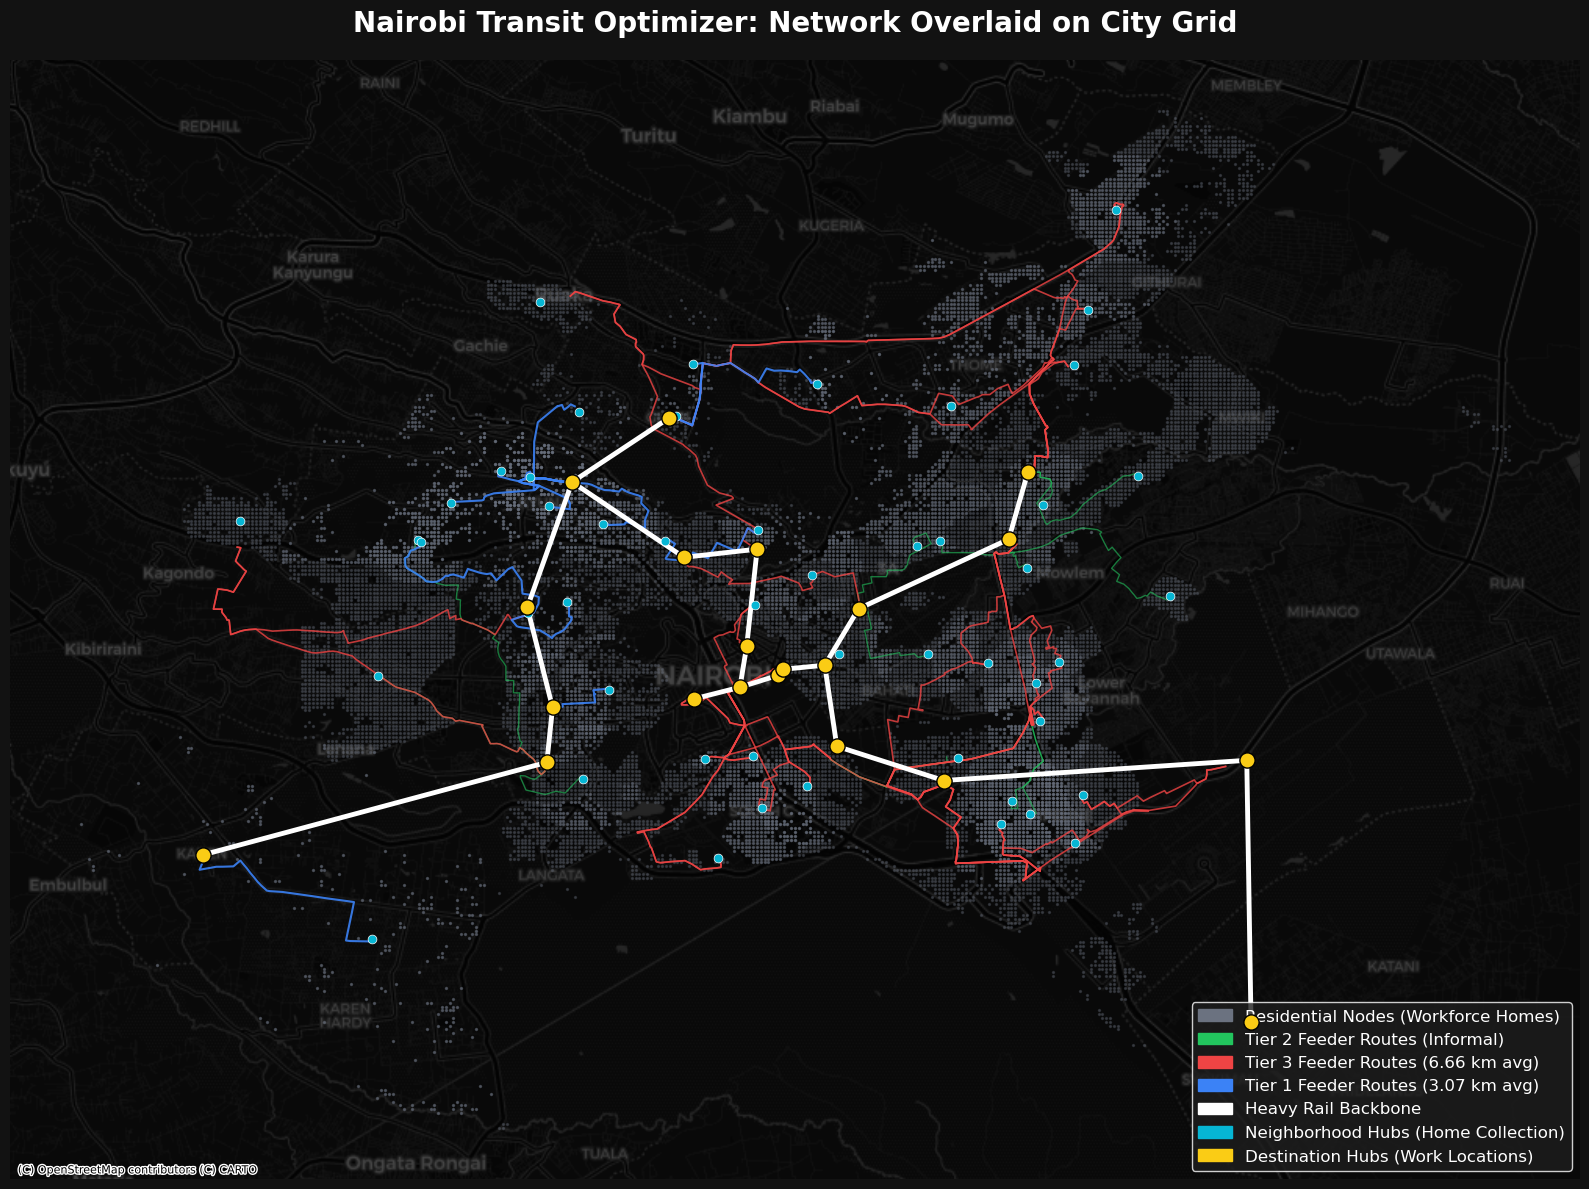

In [23]:
# ==========================================
# PHASE 4: VISUALIZING THE FULL HUB-AND-SPOKE NETWORK (WITH REAL BASEMAP)
# ==========================================
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import contextily as ctx

print("Generating Dark Mode Transit Network Map with Nairobi Basemap...")

# 1. Set up the figure and Dark Mode styling
fig, ax = plt.subplots(figsize=(16, 12))
fig.patch.set_facecolor('#121212')  
ax.set_facecolor('#121212')

# 2. Isolate ALL Tiers for the Feeder Routes
tier1_routes = gdf_brt_web[gdf_brt_web['tier'] == 'Tier_1_WhiteCollar']
tier3_routes = gdf_brt_web[gdf_brt_web['tier'] == 'Tier_3_MiddleIncome']
tier2_routes = gdf_brt_web[~gdf_brt_web['tier'].isin(['Tier_1_WhiteCollar', 'Tier_3_MiddleIncome'])]

# 3. Plot the layers (Strictly Bottom to Top)
# Layer A: Residential Nodes (The "Leaves")
gdf_orig_web.plot(ax=ax, color='#6b7280', markersize=2, alpha=0.3, zorder=1)

# Layer B: Feeder Routes (Tier 2 Informal) 
if not tier2_routes.empty:
    tier2_routes.plot(ax=ax, color='#22c55e', linewidth=1.0, alpha=0.6, zorder=2)

# Layer C: Feeder Routes (Tier 3 Blue-Collar) 
tier3_routes.plot(ax=ax, color='#ef4444', linewidth=1.2, alpha=0.8, zorder=3)

# Layer D: Feeder Routes (Tier 1 White-Collar)
tier1_routes.plot(ax=ax, color='#3b82f6', linewidth=1.5, alpha=0.9, zorder=4)

# Layer E: Heavy Rail Backbone 
gdf_rail_web.plot(ax=ax, color='#ffffff', linewidth=3.5, zorder=5)

# Layer F: Neighborhood Hubs (Home Hubs) 
gdf_hubs_web.plot(ax=ax, color='#06b6d4', markersize=40, edgecolor='white', linewidth=0.5, zorder=6)

# Layer G: Destination Hubs (Work Hubs) 
gdf_dest_web.plot(ax=ax, color='#facc15', markersize=120, edgecolor='black', zorder=7)

# --- NEW: ADD THE REAL WORLD MAP ---
# This pulls the CARTO Dark Matter tiles from the internet and places them underneath everything (zorder=0)
try:
    ctx.add_basemap(ax, crs=gdf_brt_web.crs.to_string(), source=ctx.providers.CartoDB.DarkMatter, zorder=0)
except Exception as e:
    print(f"Could not load basemap (check internet connection): {e}")
# -----------------------------------

# 4. Create a custom legend
grey_dot = mpatches.Patch(color='#6b7280', label='Residential Nodes (Workforce Homes)')
green_line = mpatches.Patch(color='#22c55e', label='Tier 2 Feeder Routes (Informal)')
red_line = mpatches.Patch(color='#ef4444', label='Tier 3 Feeder Routes (6.66 km avg)')
blue_line = mpatches.Patch(color='#3b82f6', label='Tier 1 Feeder Routes (3.07 km avg)')
white_line = mpatches.Patch(color='#ffffff', label='Heavy Rail Backbone')
cyan_dot = mpatches.Patch(color='#06b6d4', label='Neighborhood Hubs (Home Collection)')
yellow_dot = mpatches.Patch(color='#facc15', label='Destination Hubs (Work Locations)')

legend_handles = [grey_dot, green_line, red_line, blue_line, white_line, cyan_dot, yellow_dot]

legend = ax.legend(handles=legend_handles, 
                   loc='lower right', 
                   facecolor='#1e1e1e', 
                   edgecolor='white',
                   labelcolor='white',
                   fontsize=12)

# 5. Final Styling touches
ax.set_title("Nairobi Transit Optimizer: Network Overlaid on City Grid", 
             color='white', fontsize=20, fontweight='bold', pad=20)
ax.axis('off')  # Hide the coordinate axes to let the basemap shine

plt.tight_layout()
plt.show()